<a href="https://colab.research.google.com/github/naoya1110/zakkuri_AI_nyumon/blob/main/Introduction_to_Image_Classification_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類AI超ざっくり入門

## はじめに/Introduction
うどんの写真からどこのうどん屋か当てる画像分類AIを作ってみましょう。

### PyTorch
DLフレームワークのPyTorchを使います。

In [ ]:
import torch
torch.__version__

### GPU

GPUが使える状態であることを確認します。

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

### 基本のPythonパッケージ

必要なPythonパッケージをインポートします。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import gdown
import random
import shutil

## データの準備/Data Preperation

### udon_dataset_20.zipのダウンロード

以下のセルを実行することでudon_dataset_20.zipがダウンロードされます。

In [ ]:
gdown.download('https://drive.google.com/uc?id=1exNFrdqACLRf8yBhDBDEY-5pAUXXXvrI', 'udon_dataset_20.zip', quiet = False)

### udon_dataset_20.zipの解凍と不要なデータの削除

In [ ]:
N = 3 # うどん屋の数 2-20の値

dataset_dir = "udon_dataset_20"

if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)
    
! unzip udon_dataset_20.zip > /dev/null 2>&1

for subdir in ["train", "test"]:
    subsubdirs = sorted(os.listdir(os.path.join(dataset_dir, subdir)))
    for subsubdir in subsubdirs[N:]:
        shutil.rmtree(os.path.join(dataset_dir, subdir, subsubdir))


udon_dataset_20に含まれるデータの数を見てみましょう。

In [ ]:
for subdir in ["train", "test"]:
    print(subdir)
    subsubdirs = sorted(os.listdir(os.path.join(dataset_dir, subdir)))
    for subsubdir in subsubdirs:
        filenames = os.listdir(os.path.join(dataset_dir, subdir, subsubdir))
        print("---", subsubdir, ":", len(filenames))

### Datasetオブジェクトの作成/Create Dataset Objects
以下のセルを実行し学習用とテスト用のDatasetオブジェクトを作成します。

In [ ]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=f"{dataset_dir}/train")
test_dataset = ImageFolder(root=f"{dataset_dir}/test")

print("train_dataset:", len(train_dataset))
print("test_dataset:", len(test_dataset))

train_datasetからいくつか画像を表示して確認してみましょう。

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(15):
    image, label = train_dataset[random.randint(0, len(train_dataset))]
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}") 
    plt.axis("off")

ラベルの番号とうどん屋の名前（フォルダ名）の関係は次のようになっています。

In [ ]:
classnames = {value: key[4:] for key, value in train_dataset.class_to_idx.items()}
classnames

AIのモデルに画像を入力するためにはすべての画像が同じサイズでなければなりません。
そこで再度サイズを指定してDatasetオブジェクトを作ります。

In [ ]:
from torchvision import transforms

img_size = (128, 128)

train_dataset = ImageFolder(root=f"{dataset_dir}/train",
                            transform=transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor()
                                ])
                            )

test_dataset = ImageFolder(root=f"{dataset_dir}/test",
                           transform=transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor()
                                ])
                           )

### データの分離/Train Test Split
一般的に学習用データ(train_dataset)はそのすべて学習に使用するのではなく，その一部を学習途中の検証用データ(valid_dataset)として使用します。

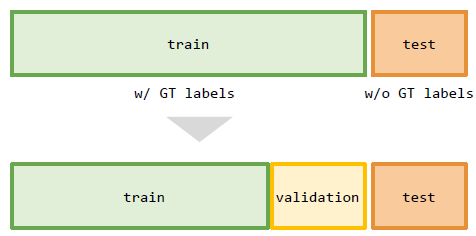

In [ ]:
from torch.utils.data import random_split

n_samples = len(train_dataset)
train_size = int(n_samples * 0.8)    # 80% will be training data
valid_size = n_samples - train_size  # 20% will be validation data

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("train data", len(train_dataset))
print("validation data", len(valid_dataset))

### DataLoaderオブジェクトの作成/Create DataLoader Objects

AIモデルにデータを入力するためのDataLoaderオブジェクトを作ります。

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

## AIモデルの作成/Build AI Models

### VGG16

In [ ]:
import torch.nn as nn
import torchvision.models as models

def create_vgg16(outputs=10, freeze=False):
    
    # 事前学習モデルの読み込み
    model = models.vgg16(pretrained=True)

    # パラメータのフリーズ
    if freeze:
        for param in model.parameters():
            param.requires_grad = False  
    
    # 出力層の付け替え
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, outputs)   # replace the last layer

    return model

model = create_vgg16(outputs=len(classnames), freeze=False)
print(model)

### ResNet50

In [ ]:
def create_resnet50(outputs=10, freeze=False):
    
    # 事前学習モデルの読み込み
    model = models.resnet50(pretrained=True)
    
    # パラメータのフリーズ
    if freeze:
        for param in model.parameters():
            param.requires_grad = False   

    # 出力層の付け替え
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, outputs)
    
    return model

model = create_resnet50(outputs=len(classnames), freeze=False)
print(model)

### EfficentNet B0

In [ ]:
def create_efficientnetB0(outputs=10, freeze=False):
    
    # 事前学習モデルの読み込み
    model = models.efficientnet_b0(pretrained=True)
    
    # パラメータのフリーズ
    if freeze:
        for param in model.parameters():
            param.requires_grad = False   

    # 出力層の付け替え
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, 10)
    
    return model

model = create_efficientnetB0(outputs=len(classnames), freeze=False)
print(model)

## AIモデルの学習/AI Model Training

### 損失関数/Loss Function
AIモデルの推論結果がどの程度間違っているかを評価するための損失関数を定義します。

In [ ]:
loss_func = nn.CrossEntropyLoss()

### 最適化関数/Optimizer
AIモデルのパラメータを更新するためのアルゴリズム最適化関数を定義します。

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### 学習ループ/Training Loop







In [ ]:
model = create_vgg16(outputs=len(classnames), freeze=True)
#model = create_resnet50(outputs=len(classnames), freeze=True)
#model = create_efficientnetB0(outputs=len(classnames), freeze=False)


model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 5

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    valid_correct_count = 0
    valid_accuracy = 0
    valid_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(valid_loader)
        pbar.set_description("Valid") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            valid_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            valid_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    valid_accuracy = valid_correct_count.item()/len(valid_dataset)   # determin accuracy for test data
    train_loss = train_loss/len(train_loader)       # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)       # determin loss for validation data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)
    
    print("---------------------")

### 学習曲線/Learning Curves

正解率と損失がどのように変化したかを可視化してみてみましょう。

In [ ]:
plt.figure(figsize=(5,5))
plt.rcParams["font.size"]=12

plt.subplot(2,1,1)
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.tight_layout()

## 学習済みAIモデルの評価/Evaluation of Trained AI Model

### テストデータに対する正解率

In [ ]:
test_correct_count = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():   # disable autograd for saving memory usage
    model.eval()        # set model to evaluation mode

    for x_batch, y_batch in test_loader:      # take mini batch data from test_loader 

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        p_batch = model(x_batch)              # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
        test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.cpu().numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.cpu().numpy())  # append p_batch_label in p_label_all

test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

### 混同行列/Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(7,6))
labels = list(classnames.values())

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=labels, yticklabels=labels, square=True)

plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.title("confusion matrix")

## AIモデルの実装/Deploy AI Model
1枚の画像を学習済みAIモデルに入力し推論できるようにしましょう。

In [ ]:
## 前処理の関数など
def preprocess(img):
    x = img.resize((96, 96))
    x = np.array(x)/255
    x = x.transpose((2, 0, 1))
    x = torch.tensor(x, dtype=torch.float32)
    x = x.to(device)
    x = x[None, ...]
    return x

softmax = nn.Softmax(dim=0)

In [ ]:
from PIL import Image

filepath = "/content/udon_dataset_20/test/000_suzaki-shokuryohinten_mitoyo/640x640_rect_101543878.jpg"
img = Image.open(filepath)
plt.imshow(img)


with torch.no_grad():
    model.eval()
    model = model.to(device)
    
    x = preprocess(img)
    y = model(x)[0]
    probs = softmax(y)
    probs = probs.cpu().numpy()
    idx = np.argmax(probs)
    probability = probs[idx].item()
    prediction = classnames[idx]

print("--------------")
print(f"Prediction Index: {idx}")
print(f"Prediction Label: {prediction}")
print(f"Probability: {probability:.2%}")

print("--------------")
for key, value in classnames.items():
    print(value, f"{probs[key]:.2%}")